In [1]:
"""
Original file was Marley's, shared in collab

Here Miasya is toying with the visualizations to produce figures to feed into a CNN for classification
Her next step is to create a loop that generated a lot of images, and labels the file with the appropriate marker
As well as the time

"""

import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pytz
from scipy import signal

In [2]:
markers = '001_trial1_right_log_18-09-46-931825.txt'
fname = '001_trial1_right_OpenBCI-RAW-2020-02-09_17-59-22.txt'

df = pd.read_csv(markers)
start = df['timestamp(ms)'].iloc[0]
end = df['timestamp(ms)'].iloc[-1]
channel = (1,2,3,4,13)
data = np.loadtxt(fname,
                  delimiter=',',
                  skiprows=7,
                  usecols=channel)
eeg = data[:,:-1]
timestamps = data[:,-1]

In [3]:
def get_ms(str_time):
    """
    Convert timestamp in keyboard markings file to unix milliseconds
    inputs:
      str_time (string)
    outputs:
      milliseconds (float)
    """
    date_time_str = '2020-02-09 ' + str_time
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S:%f')

    timezone = pytz.timezone('America/New_York')
    timezone_date_time_obj = timezone.localize(date_time_obj)
    return timezone_date_time_obj.timestamp() * 1000

In [4]:
SAMPLING_FREQ = 250
WINDOW_SIZE = 1000 # we can play around with this
FIGURE_NAME = "test.jpeg"
MARKER_SHIFT = 750 # experimentally determined that to make the keypress line up with spike, do - 750

def notch_mains_interference(data):
    """
    Notch filter 57-63 Hz
    Inputs:
        1 channel of signal in time domain
    Outputs:
        2 channel of signal but filtered
    """
    notch_freq_Hz = np.array([60.0])  # main + harmonic frequencies
    for freq_Hz in np.nditer(notch_freq_Hz):  # loop over each target freq
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])  # set the stop band
        b, a = signal.butter(3, bp_stop_Hz / (SAMPLING_FREQ / 2.0), 'bandstop')
        arr = signal.lfilter(b, a, data, axis=0)
        print("Notch filter removing: " +
              str(bp_stop_Hz[0]) +
              "-" +
              str(bp_stop_Hz[1]) +
              " Hz")
    return arr

def filter_signal(arr, lowcut=4.0, highcut=60.0, order=3, notch=True):
    """
    Applies following changes to 1 channel:
    - Notch filter (if specified in arg)
    - Butterworth filter
    
    Inputs:
        1 channel of signal in time domain, lowcut, highcut...
    Outputs:
        2 channel of signal but filtered
    """
    if notch:
        arr = notch_mains_interference(arr)
    nyq = 0.5 * SAMPLING_FREQ
    b, a = signal.butter(1, [lowcut / nyq, highcut / nyq], btype='band')
    for i in range(0, order):
        arr = signal.lfilter(b, a, arr, axis=0)
    return arr


def get_spectral_content(ch, fs_Hz, shift=0.1):
    """
    Inputs:
        ch = channel of filtered data
        fs_Hz = sampling frequency
        shift = specifies overlap of windows (?)
    Outputs:
        spectral frequencies, power spectral densities...
    """
    NFFT = fs_Hz*2
    overlap = NFFT - int(shift * fs_Hz)
    spec_PSDperHz, spec_freqs, spec_t = mlab.specgram(np.squeeze(ch),
                                   NFFT=NFFT,
                                   window=mlab.window_hanning,
                                   Fs=fs_Hz,
                                   noverlap=overlap
                                   ) # returns PSD power per Hz
    # convert the units of the spectral data
    spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT)
    return spec_t, spec_freqs, spec_PSDperBin  # dB re: 1 uV

In [33]:
def plot_specgram(spec_freqs, spec_PSDperBin,title,shift,i=1):
    """
    Miasya be messing with this a lot lol
    she wants 1 figure with stacked channels for each window of a letter
    
    
    """
    f_lim_Hz = [0, 30]   # frequency limits for plotting is 0 to 30
    
    
    spec_t = [idx*.1 for idx in range(len(spec_PSDperBin[0]))]
    plt.subplot(4,1,i)
    #plt.title(title)
    plt.pcolor(spec_t, spec_freqs, 10*np.log10(spec_PSDperBin))  # dB re: 1 uV
    plt.clim([-25,26])
    plt.xlim(spec_t[0], spec_t[-1]+1)
    plt.ylim(f_lim_Hz)
    #plt.axis("off")
    #plt.xlabel('Time (sec)')
    #plt.ylabel('Frequency (Hz)')
    plt.subplots_adjust(hspace=0)
    #plt.savefig(FIGURE_NAME, bbox_inches=a)
    plt.savefig(FIGURE_NAME)
    

In [6]:
start_idx = np.where(timestamps > get_ms(start))[0][0]
end_idx = np.where(timestamps > get_ms(end))[0][0]

markings = [get_ms(val) for val in df['timestamp(ms)'].values[::2]]
labels = df.values[:,1]

In [7]:
# list of tuples where its (label, start time, end time) and centred around a label
segment_start_ends = []

# for every label, i want a window centred around that point
for i,mark in enumerate(markings):
    segment_start_ends.append((labels[i*2], int((mark-get_ms(start)-WINDOW_SIZE/2-MARKER_SHIFT)), int((mark-get_ms(start)+WINDOW_SIZE/2-MARKER_SHIFT))))
    
segment_start_ends = segment_start_ends[1:-1] #remove the first and last because of artifacts and index issues?
segment_start_ends

[('j', 654, 1654),
 ('k', 4795, 5795),
 (';', 6812, 7812),
 ('k', 10386, 11386),
 ('l', 12952, 13952),
 ('k', 15630, 16630),
 ('j', 18537, 19537),
 (';', 21863, 22863),
 (';', 24696, 25696),
 ('k', 27966, 28966),
 (';', 30986, 31986),
 ('l', 33729, 34729),
 ('l', 36706, 37706),
 (';', 39727, 40727),
 ('k', 43014, 44014),
 (';', 45888, 46888),
 (';', 48625, 49625),
 ('i', 52491, 53491),
 ('l', 54884, 55884),
 (';', 57778, 58778),
 ('l', 60993, 61993),
 ('k', 63664, 64664),
 ('k', 66687, 67687),
 ('l', 69663, 70663),
 ('j', 72801, 73801),
 ('j', 75642, 76642),
 ('l', 78695, 79695),
 (';', 81750, 82750)]

In [9]:
for idx, ch in enumerate(eeg.T):
    ch = filter_signal(ch)

Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz


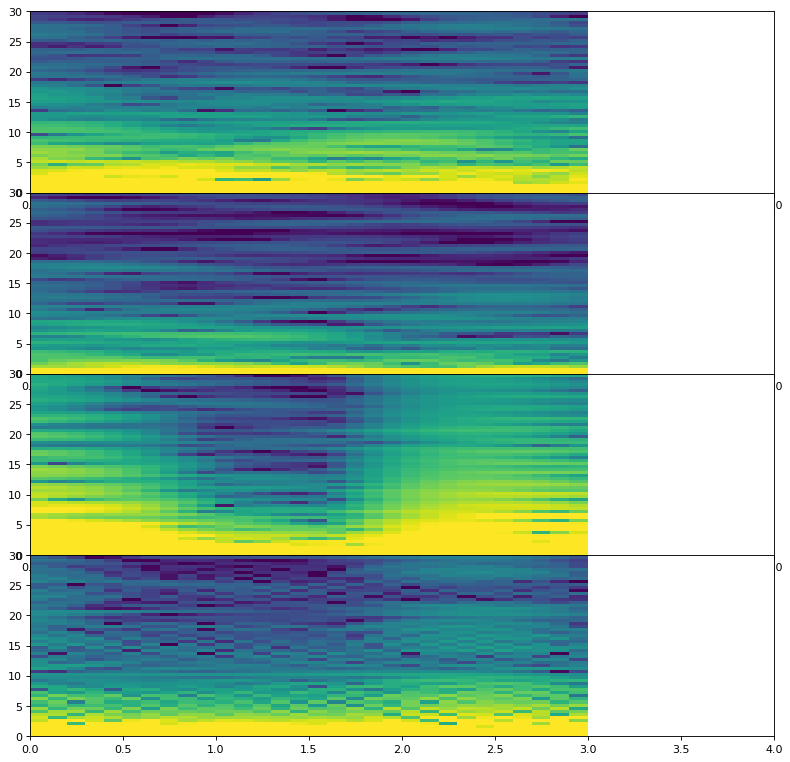

In [35]:
# Get all 4 channels
from matplotlib.transforms import Bbox
a = Bbox(np.array([[1.55,0],[3.85,11.9]]))

fig=plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')

ARBIT_START = 20 * 1000 # arbitrary starting point
FIVE_S = 5 * 250 # five seconds and we will make this work with inches


for idx, ch in enumerate(eeg.T):
    t, spec_freqs, spec_PSDperBin = get_spectral_content(ch[ARBIT_START:ARBIT_START+FIVE_S], 250)
    plot_specgram(spec_freqs, spec_PSDperBin,'channel {}'.format(idx + 1), 0, idx+1)
    #plt.savefig(mark+"_"+str(start)+"_"+str(end)+"_"+FIGURE_NAME)
plt.savefig("aaaaaaaa"+FIGURE_NAME, bbox_inches=a)